In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path
path = Path.cwd().parents[0]
if str(path) not in sys.path:
    sys.path.append(str(path))

In [2]:
# Imports
trials = 50
n=100

results_kl = torch.load(path / "causalklgp/cbohealth_causalklgp_ntrial={0}_n={1}.pt".format(trials,n),
                         weights_only = True)
results_bimp = torch.load(path / "bayesimp/cbohealth_bayesimp_ntrial={0}_n={1}.pt".format(trials,n),
                         weights_only = True)
results_bgp = torch.load(path / "sampling_cbo/cbohealth_rkhscbo_ntrial={0}_n={1}.pt".format(trials,n),
                         weights_only = True)
results_bo = torch.load(path / "naive_bo/cbohealth_naivebo_ntrial={0}_n={1}.pt".format(trials,n),
                         weights_only = True)

results = [results_bo,results_bgp,results_bimp,results_kl]

# Getting dimensions and names
n_result_kl = len(results_kl)
n_model_kl = int(n_result_kl/trials)
n_result_bimp = len(results_bimp)
n_model_bimp = int(n_result_bimp/trials)
n_result_bgp = len(results_bgp)
n_model_bgp = int(n_result_bgp/trials)
n_result_bo = len(results_bo)
n_model_bo = int(n_result_bo/trials)
n_model = [n_model_bo, n_model_bgp, n_model_bimp, n_model_kl]

In [3]:
EYdoX_eval_kl = torch.zeros((len(results_kl[0]['EYdoXeval']), trials, n_model_kl))
EYdoX_eval_bimp = torch.zeros((len(results_bimp[0]['EYdoXeval']), trials, n_model_bimp))
EYdoX_eval_bgp = torch.zeros((len(results_bgp[0]['EYdoXeval']), trials, n_model_bgp))
EYdoX_eval_bo = torch.zeros((len(results_bo[0]['EYdoXeval']), trials, n_model_bo))

EYdoX_eval = [EYdoX_eval_bo,EYdoX_eval_bgp,EYdoX_eval_bimp,EYdoX_eval_kl]

for r in range(len(n_model)):
    for m in range(n_model[r]):
            for t in range(trials):
                EYdoX_eval[r][:,t,m] = results[r][trials*m + t]['EYdoXeval'][:,0]

In [4]:
doX_eval_kl = torch.zeros((len(results_kl[0]['doXeval']), trials, n_model_kl))
doX_eval_bimp = torch.zeros((len(results_bimp[0]['doXeval']), trials, n_model_bimp))
doX_eval_bgp = torch.zeros((len(results_bgp[0]['doXeval']), trials, n_model_bgp))
doX_eval_bo = torch.zeros((len(results_bo[0]['doXeval']), trials, n_model_bo))

doX_eval = [doX_eval_bo,doX_eval_bgp,doX_eval_bimp,doX_eval_kl]

for r in range(len(n_model)):
    for m in range(n_model[r]):
            for t in range(trials):
                doX_eval[r][:,t,m] = results[r][trials*m + t]['doXeval'][:,0]

In [5]:
# Getting best values
iters = len(results_kl[0]['EYdoXeval'])
best_eval_bo = torch.zeros((iters, trials, n_model_bo))
best_eval_bgp = torch.zeros((iters, trials, n_model_bgp))
best_eval_bimp = torch.zeros((iters, trials, n_model_bimp))
best_eval_kl = torch.zeros((iters, trials, n_model_kl))

best_eval = [best_eval_bo,best_eval_bgp,best_eval_bimp, best_eval_kl]

best_recorded_eval = 100
for r in range(len(n_model)):
    for m in range(n_model[r]):
        for t in range(trials):
            for i in range(iters):
                if i == 0:
                    best_eval[r][i,t,m] = EYdoX_eval[r][i,t,m] 
                else:
                    if EYdoX_eval[r][i,t,m] < best_eval[r][:i,t,m].min():
                        best_eval[r][i,t,m] = EYdoX_eval[r][i,t,m]   
                    else:
                         best_eval[r][i,t,m] =  best_eval[r][i-1,t,m] 
                        
            # Standardising best evaluation
            best_eval[r][:,t,m] *= 1/best_eval[r][:,t,m].min()*4.875

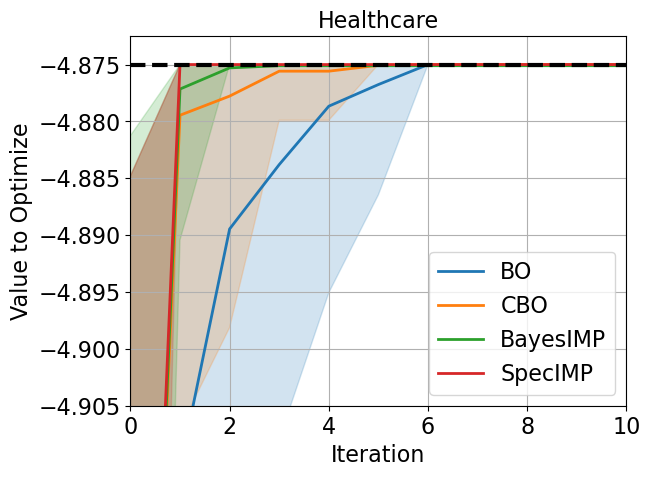

In [6]:
# Parameters
i = 11
m_inds = [[0], [0], [0], [2]]  # Model indices
names = ["BO", "CBO", "BayesIMP", "IMPspec"]  # Method names

# Get the default color cycle from Matplotlib
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Start plotting
for r in range(len(n_model)):
    color = colors[r % len(colors)]  # Use r-th color from the default color cycle
    for m in m_inds[r]:
        plt.plot(
            -best_eval[r][..., m].mean(1)[:i], 
            label=names[r], 
            lw=2.0, 
            ls="solid", 
            color=color
        )
        plt.fill_between(
            torch.arange(min(len(best_eval[r]), i)),
            torch.minimum(-best_eval[r][..., m].quantile(0.95, 1)[:i], torch.tensor(-1.0)),
            torch.minimum(-best_eval[r][..., m].quantile(0.05, 1)[:i], torch.tensor(-1.0)),
            alpha=0.2,
            color=color  # Match the fill color with the plot color
        )

# Add a horizontal line at the specified value
plt.axhline(-4.875, color="black", ls="dashed", lw=3)

# Add grid, set limits, and adjust tick sizes
plt.grid()
plt.ylim(-4.905, -4.8725)
plt.xlim(0, 10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add legend, labels, and title with specified font size
plt.legend(fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Value to Optimize", fontsize=16)
plt.title("Healthcare", fontsize=16)

# Save the plot with tight bounding box
plt.savefig("CBO_convergence_profile_healthcare", bbox_inches="tight")

# Show the plot
plt.show()


In [7]:
# Loading in other plots
path = Path.cwd().parents[1]
if str(path) not in sys.path:
    sys.path.append(str(path))
results_fd = torch.load(path / "Simulation/results_agg/fd_best_evals.pt",
                         weights_only = True)
results_bd = torch.load(path / "Simulation/results_agg/bd_best_evals.pt",
                         weights_only = True)

In [8]:
# Getting list of best_evals 
best_eval_bd, best_bd = results_bd[0], results_bd[1]
best_eval_fd, best_fd = results_fd[0], results_fd[1]
best_eval, best = best_eval, 4.875

/tmp/ipykernel_96761/4222678151.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  upper_bound = torch.minimum(upper_bound, torch.tensor(ref_value))


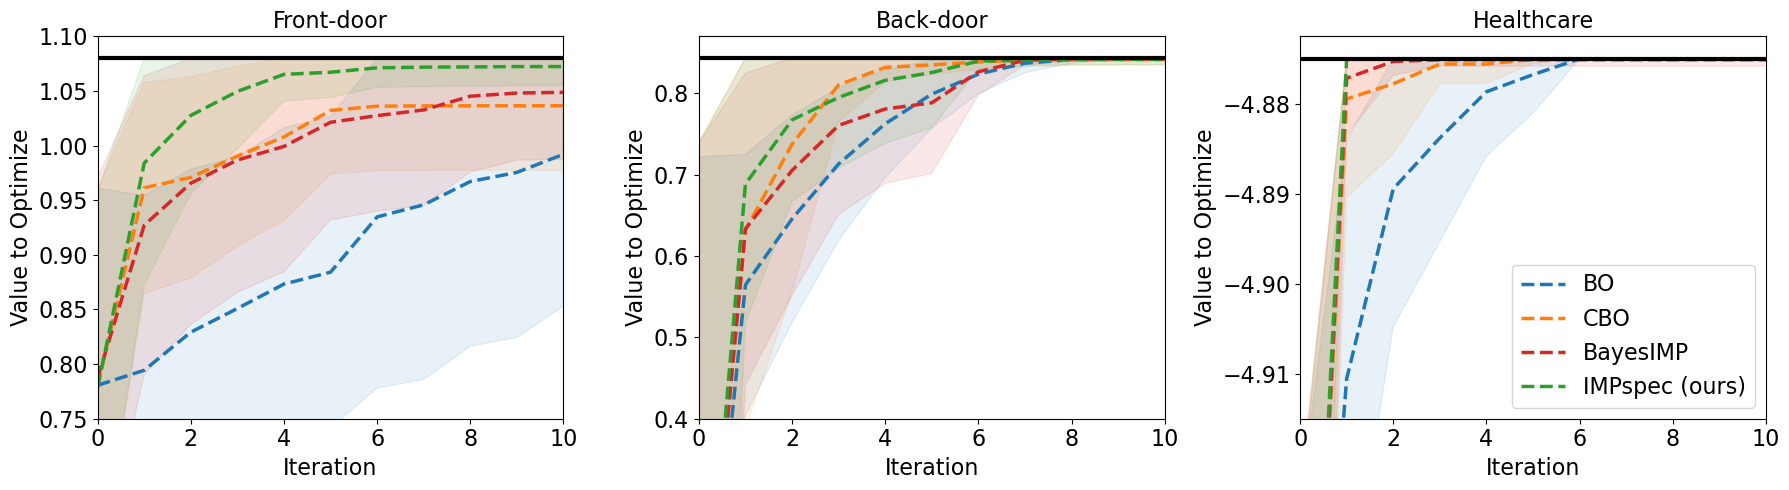

In [12]:
import matplotlib.pyplot as plt
import torch

# Parameters
i = 20
m_inds = [[0], [0], [0], [2]]  # Model indices for Healthcare plot
names = ["BO", "CBO", "BayesIMP", "IMPspec (ours)"]  # Method names

# Plot options
common_alpha = 0.1  # Common alpha value for fill_between
quantile_upper = 0.75  # Upper quantile
quantile_lower = 0.25  # Lower quantile
use_std_dev = True  # Set to True to use ± standard deviation instead of quantiles

# Ordering of plots (default is [0, 1, 2] for current order)
plot_order = [0,1,2]  # Specify the desired order of the plots (0: Front-door, 1: Back-door, 2: Healthcare)

# Line width options
method_linewidth = 2.5  # Line width for the methods
dashed_linewidth = 3.0  # Line width for the black dashed line

# Get the default color cycle from Matplotlib
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[2],colors[3] = colors[3],colors[2]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 3 subplots side by side

# Reference values for the dashed lines
ref_values = [best_fd, -best_bd, 4.875]

# Plotting function for Front-door and Back-door
def plot_convergence_simple(ax, best_eval_data, ref_value, title, ylim, ylabel, negate=False):
    for r in range(len(names)):
        color = colors[r % len(colors)]
        mean_values = best_eval_data[r].mean(1)[:i,0]
        if negate:
            mean_values = -mean_values

        if use_std_dev:
            std_dev = best_eval_data[r].std(1)[:i,0]
            upper_bound = mean_values + std_dev
            lower_bound = mean_values - std_dev
        else:
            upper_bound = best_eval_data[r].quantile(quantile_upper, 1)[:i, 0]
            lower_bound = best_eval_data[r].quantile(quantile_lower, 1)[:i, 0]
            if negate:
                upper_bound, lower_bound = -lower_bound, -upper_bound
        
        # Cap the upper_bound to the reference value (dashed line)
        upper_bound = torch.minimum(upper_bound, torch.tensor(ref_value))
        
        ax.plot(mean_values, label=names[r], lw=method_linewidth, ls="dashed", color=color)
        ax.fill_between(
            torch.arange(min(len(best_eval_data[r]), i)),
            upper_bound,
            lower_bound,
            alpha=common_alpha,
            color=color
        )
    ax.axhline(ref_value, color="black", ls="solid", lw=dashed_linewidth)
    ax.set_xlim(0, 10)
    ax.set_ylim(ylim)
    ax.set_xticks(range(0, 11, 2))
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel("Iteration", fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.grid(False)

# Plotting function for Healthcare plot
def plot_convergence_healthcare(ax, best_eval_data, ref_value, m_indices, title, ylim, ylabel):
    for r in range(len(names)):
        color = colors[r % len(colors)]
        for m in m_indices[r]:
            mean_values = -best_eval_data[r][..., m].mean(1)[:i]
            if use_std_dev:
                std_dev = best_eval_data[r][..., m].std(1)[:i]
                upper_bound = mean_values + std_dev
                lower_bound = mean_values - std_dev
            else:
                upper_bound = -best_eval_data[r][..., m].quantile(quantile_lower, 1)[:i]
                lower_bound = -best_eval_data[r][..., m].quantile(quantile_upper, 1)[:i]
            
            # Cap the upper_bound to the reference value (dashed line)
            upper_bound = torch.minimum(upper_bound, torch.tensor(ref_value))
            
            ax.plot(mean_values, label=names[r], lw=method_linewidth, ls="dashed", color=color)
            ax.fill_between(
                torch.arange(min(len(best_eval_data[r]), i)),
                upper_bound,
                lower_bound,
                alpha=common_alpha,
                color=color
            )
    ax.axhline(ref_value, color="black", ls="solid", lw=dashed_linewidth)
    ax.set_xlim(0, 10)
    ax.set_ylim(ylim)
    ax.set_xticks(range(0, 11, 2))
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel("Iteration", fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.grid(False)

# Subplot 1: Front-door plot with best_eval_fd
plot_convergence_simple(
    axes[plot_order[0]], 
    best_eval_fd, 
    best_fd, 
    "Front-door", 
    ylim=(0.75, 1.1), 
    ylabel="Value to Optimize"
)

# Subplot 2: Back-door plot with best_eval_bd
plot_convergence_simple(
    axes[plot_order[1]], 
    best_eval_bd, 
    -best_bd, 
    "Back-door", 
    ylim=(0.4, 0.87), 
    ylabel="Value to Optimize",
    negate=True
)

# Subplot 3: Healthcare plot with best_eval
plot_convergence_healthcare(
    axes[plot_order[2]], 
    best_eval, 
    -4.875, 
    m_inds, 
    "Healthcare", 
    ylim=(-4.915, -4.8725), 
    ylabel="Value to Optimize"
)

# Add legend to the "Healthcare" plot
axes[plot_order[2]].legend(fontsize=16)

# Adjust layout and save the combined figure
plt.tight_layout()
plt.savefig("CBO_combined_convergence_profiles", bbox_inches="tight")
plt.show()


In [11]:
n_model = [1,1,1,1]

# Parameters
iters = 10  # You can change this value to vary the number of iterations considered

# Getting regret
regret_bo_fd = torch.zeros((trials, n_model[0]))
regret_bgp_fd = torch.zeros((trials, n_model[1]))
regret_bimp_fd = torch.zeros((trials, n_model[2]))
regret_kl_fd = torch.zeros((trials, n_model[3]))

regret_bo_bd = torch.zeros((trials, n_model[0]))
regret_bgp_bd = torch.zeros((trials, n_model[1]))
regret_bimp_bd = torch.zeros((trials, n_model[2]))
regret_kl_bd = torch.zeros((trials, n_model[3]))

regret_bo_hc = torch.zeros((trials, n_model[0]))
regret_bgp_hc = torch.zeros((trials, n_model[1]))
regret_bimp_hc = torch.zeros((trials, n_model[2]))
regret_kl_hc = torch.zeros((trials, n_model[3]))

# Store regret lists in a dictionary for easier access
regret = {
    'fd': [regret_bo_fd, regret_bgp_fd, regret_bimp_fd, regret_kl_fd],
    'bd': [regret_bo_bd, regret_bgp_bd, regret_bimp_bd, regret_kl_bd],
    'hc': [regret_bo_hc, regret_bgp_hc, regret_bimp_hc, regret_kl_hc]
}

# Reference values for each case
ref_values = {'fd': best_fd, 'bd': best_bd, 'hc': 4.875}

# Iterate over methods and models to calculate regret
for r in range(len(n_model)):
    for m in range(n_model[r]):
        for t in range(trials):
            # Front-door regret
            regret['fd'][r][t, m] = (ref_values['fd'] - best_eval_fd[r][..., t, m][1:]).sum()
            # Back-door regret (negation considered)
            regret['bd'][r][t, m] = -(ref_values['bd'] - best_eval_bd[r][..., t, m][1:]).sum()
            # Healthcare regret (negation considered)
            regret['hc'][r][t, m] = -(ref_values['hc'] - best_eval[r][..., t, m][1:]).sum()

# Now, we will compute the mean ± standard deviation of these regrets and create the table
import numpy as np
from tabulate import tabulate

# Calculate the mean and standard deviation of regrets for each method and dataset
mean_sd_regret = {
    'Front-door': [(regret['fd'][r].mean(), regret['fd'][r].std()) for r in range(len(n_model))],
    'Back-door': [(regret['bd'][r].mean(), regret['bd'][r].std()) for r in range(len(n_model))],
    'Healthcare': [(regret['hc'][r].mean(), regret['hc'][r].std()) for r in range(len(n_model))]
}

# Updated method names
method_names = ["BO", "CBO", "BayesIMP", "IMPspec"]

# Initialize table data
table = []
table_headers = ['Method', 'Front-door', 'Back-door', 'Healthcare']

# Populate the table
for r, method in enumerate(method_names):
    fd_mean, fd_sd = mean_sd_regret['Front-door'][r]
    bd_mean, bd_sd = mean_sd_regret['Back-door'][r]
    hc_mean, hc_sd = mean_sd_regret['Healthcare'][r]
    
    # Format the results with the ± symbol
    fd_result = f'{fd_mean:.3f} ± {fd_sd:.3f}'
    bd_result = f'{bd_mean:.3f} ± {bd_sd:.3f}'
    hc_result = f'{hc_mean:.3f} ± {hc_sd:.3f}'
    
    table.append([method, fd_result, bd_result, hc_result])

# Identify the best (smallest) regret in each case
for col in range(1, 4):  # Columns 1, 2, 3 correspond to Front-door, Back-door, and Healthcare
    best_idx = np.argmin([float(row[col].split(' ± ')[0]) for row in table])
    mean_regret, sd_regret = table[best_idx][col].split(' ± ')
    table[best_idx][col] = f'\\textbf{{{mean_regret}}} ± {sd_regret}'

# Generate the LaTeX table using tabulate and wrap it with \resizebox{\textwidth}{!}{...}
latex_table = "\\resizebox{\\textwidth}{!}{\n" + tabulate(
    table, 
    headers=table_headers, 
    tablefmt='latex_booktabs', 
    stralign='center', 
    floatfmt=".3f"
) + "\n}"

# Fix LaTeX escape sequences
latex_table = latex_table.replace('\\textbackslash{}', '\\')
latex_table = latex_table.replace('\\textbf\\{', '\\textbf{')
latex_table = latex_table.replace('\\}', '}')

# Print the LaTeX table
print(latex_table)



\resizebox{\textwidth}{!}{
\begin{tabular}{cccc}
\toprule
  Method  &       Front-door       &       Back-door        &       Healthcare       \\
\midrule
    BO    &     1.753 ± 1.326      &     0.760 ± 0.519      &     0.064 ± 0.029      \\
   CBO    &     0.656 ± 0.604      &     0.383 ± 0.427      &     0.008 ± 0.018      \\
 BayesIMP &     0.698 ± 0.825      &     0.570 ± 0.555      &     0.003 ± 0.010      \\
 SpecIMP  & \textbf{0.247} ± 0.284 & \textbf{0.335} ± 0.420 & \textbf{0.000} ± 0.000 \\
\bottomrule
\end{tabular}
}


In [13]:
import numpy as np
from tabulate import tabulate

# Calculate the mean and standard deviation of regrets for each method and dataset
mean_sd_regret = {
    'Front-door': [(regret_fd[r].mean(), regret_fd[r].std()) for r in range(len(n_model))],
    'Back-door': [(regret_bd[r].mean(), regret_bd[r].std()) for r in range(len(n_model))],
    'Healthcare': [(regret_hc[r].mean(), regret_hc[r].std()) for r in range(len(n_model))]
}

# Updated method names
method_names = ["BO", "CBO", "BayesIMP", "IMPspec"]

# Initialize table data
table = []
table_headers = ['Method', 'Front-door', 'Back-door', 'Healthcare']

# Populate the table
for r, method in enumerate(method_names):
    fd_mean, fd_sd = mean_sd_regret['Front-door'][r]
    bd_mean, bd_sd = mean_sd_regret['Back-door'][r]
    hc_mean, hc_sd = mean_sd_regret['Healthcare'][r]
    
    # Format the results with the ± symbol
    fd_result = f'{fd_mean:.3f} ± {fd_sd:.3f}'
    bd_result = f'{bd_mean:.3f} ± {bd_sd:.3f}'
    hc_result = f'{hc_mean:.3f} ± {hc_sd:.3f}'
    
    table.append([method, fd_result, bd_result, hc_result])

# Identify the best (smallest) regret in each case
for col in range(1, 4):  # Columns 1, 2, 3 correspond to Front-door, Back-door, and Healthcare
    best_idx = np.argmin([float(row[col].split(' ± ')[0]) for row in table])
    mean_regret, sd_regret = table[best_idx][col].split(' ± ')
    table[best_idx][col] = f'\\textbf{{{mean_regret}}} ± {sd_regret}'

# Generate the LaTeX table using tabulate and wrap it with \resizebox{\textwidth}{!}{...}
latex_table = "\\resizebox{\\textwidth}{!}{\n" + tabulate(
    table, 
    headers=table_headers, 
    tablefmt='latex_booktabs', 
    stralign='center', 
    floatfmt=".3f"
) + "\n}"

# Fix LaTeX escape sequences
latex_table = latex_table.replace('\\textbackslash{}', '\\')
latex_table = latex_table.replace('\\textbf\\{', '\\textbf{')
latex_table = latex_table.replace('\\}', '}')

# Print the LaTeX table
print(latex_table)


NameError: name 'regret_fd' is not defined

In [14]:
# Getting regret
iters = len(results_kl[0]['EYdoXeval'])
regret_bo = torch.zeros((trials, n_model_bo))
regret_bgp = torch.zeros((trials, n_model_bgp))
regret_bimp = torch.zeros((trials, n_model_bimp))
regret_kl = torch.zeros((trials, n_model_kl))

regret = [regret_bo,regret_bgp,regret_bimp,regret_kl]

for r in range(len(n_model)):
    for m in range(n_model[r]):
        for t in range(trials):
            regret[r][t,m] = (best_eval[r][...,t,m]-(-4.875)).sum()

In [15]:
# Getting first iteration for convergence
iters = len(results_kl[0]['EYdoXeval'])
convergence_time_bo = torch.zeros((trials, n_model_bo))
convergence_time_bgp = torch.zeros((trials, n_model_bgp))
convergence_time_bimp = torch.zeros((trials, n_model_bimp))
convergence_time_kl = torch.zeros((trials, n_model_kl))

convergence_time = [convergence_time_bo,convergence_time_bgp,convergence_time_bimp,convergence_time_kl]

for r in range(len(n_model)):
    for m in range(n_model[r]):
        for t in range(trials):
            evals = results[r][trials*m + t]['doXeval'][:,0]
            if evals.max() == 1.0:
                convergence_time[r][t,m] = torch.where(evals == 1.0)[0].min()
            else:
                convergence_time[r][t,m] = len(evals)

In [16]:
import seaborn as sns
import numpy as np

# Example data generation
N = trials  # Number of trials
M = len(n_model)    # Number of models

# Simulated estimation results as a PyTorch tensor
data_tensor = torch.zeros(N, M)

for r in range(M):
    data_tensor[:,r] = convergence_time[r][:,m_inds[r]][:,0]
    data_tensor[:,r] = regret[r][:,m_inds[r]][:,0]

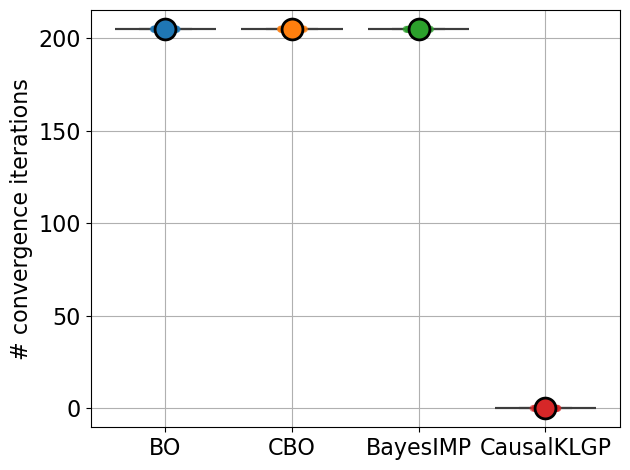

In [17]:
# Convert the tensor to a numpy array and then to a long format for seaborn
data_array = data_tensor.numpy()
data_long = np.vstack([np.column_stack((np.repeat(names[i], N), data_array[:, i])) for i in range(M)])

# Convert the numpy array to appropriate data types for seaborn
models = data_long[:, 0]
estimation_results = data_long[:, 1].astype(float)

# Set up the matplotlib figure
#plt.figure(figsize=(6, 5))

# Use the first four default matplotlib colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:M]

# Overlay a stripplot to show individual data points
sns.stripplot(x=models, y=estimation_results, hue=models, palette=colors, size=5, color='black', alpha=0.5, jitter=True, dodge=False, legend=False)

# Create a box plot with enhanced aesthetics
sns.boxplot(x=models, y=estimation_results, hue=models, palette=colors, linewidth=1.5, fliersize=0, dodge=False, legend=False)

# Add a gradient background
for i in range(M):
    plt.gca().patches[i].set_facecolor(colors[i])
    plt.gca().patches[i].set_edgecolor('black')
    plt.gca().patches[i].set_alpha(0.7)

# Add a title and labels with some styling
plt.ylabel('# convergence iterations', fontsize=16)
# Change grid lines to solid
plt.grid()

# Calculate and label the mean instead of the median
means = [np.mean(estimation_results[models == names[i]]) for i in range(M)]
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color=colors[i], markersize=15, markeredgewidth=2, markeredgecolor='black', zorder = 100)


# Customizing the ticks and spines for a cleaner look
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0.5,10)


# Show the plot
plt.tight_layout()
plt.savefig("CBO_box_plot", bbox_inches = "tight")